# A/B-тестирование гипотезы для интернет-магазина

**Цель исследования:**

В ходе данного исследования необходимо решить следующие задачи:

- Выполнить приоритизацию гипотез, сформулированных отделом маркетинга
- Провести анализ A/B-теста выбранной гипотезы 

**Описание данных:**

hypothesis.csv - информация о гипотезах по увеличению выручки интернет-магазина:

- Hypothesis — краткое описание гипотезы
- Reach — охват пользователей по 10-балльной шкале
- Impact — влияние на пользователей по 10-балльной шкале
- Confidence — уверенность в гипотезе по 10-балльной шкале
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы

orders.csv - информация о заказах:

- transactionId — идентификатор заказа
- visitorId — идентификатор пользователя, совершившего заказ
- date — дата, когда был совершён заказ
- revenue — выручка заказа
- group — группа A/B-теста, в которую попал заказ

visitors.csv - информация о посещениях клиентов:

- date — дата
- group — группа A/B-теста
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка данных и подготовка их к анализу

In [1]:
#загрузим библиотеки, необходимые для работы
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/hypothesis.csv', sep=',')
orders = pd.read_csv('/datasets/orders.csv', sep=',')
visitors = pd.read_csv('/datasets/visitors.csv', sep=',')

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
data

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
data.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'efforts']

**- Проверка на наличие пропусков.**

In [6]:
data.isna().sum()

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

In [7]:
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [8]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

В датасетах пропуски отсутствуют.

**- Проверка таблицы на наличие полных дубликатов**

In [9]:
data.duplicated().sum()

0

In [10]:
orders.duplicated().sum()

0

In [11]:
visitors.duplicated().sum()

0

Полные дубликаты в таблицах отсутствуют.

**- Проверка соотвествия типов данных сохраненным значениям.**

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Столбец date в таблице orders имеет некорректный тип. Выполним преобразование в datetime.

In [14]:
# выполним преобразования типа столбца с датой из строкового в datetime
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [15]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Столбец date в таблице visitors имеет некорректный тип. Выполним преобразование в datetime.

In [16]:
# выполним преобразования типа столбца с датой из строкового в datetime
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

Данные загружены и готовы к проведению анализа.

## Приоритизация гипотез

Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [17]:
data['ICE'] = data['impact'] * data['confidence'] / data['efforts']

In [18]:
round(data.sort_values(by = 'ICE', ascending = False)[['hypothesis', 'ICE']], 2)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Теперь применим фреймворк RICE для приоритизации гипотез и также отсортируем их по убыванию приоритета.

In [19]:
data['RICE'] = data['reach'] * data['impact'] * data['confidence'] / data['efforts']

In [20]:
round(data[["hypothesis", "RICE"]].sort_values(by="RICE", ascending=False), 2)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [21]:
data[['hypothesis', 'reach', 'RICE']].sort_values(by="RICE", ascending=False)

,hypothesis,reach,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,3.0


Наиболее перспекивные гипотезы по ICE:
1. Запустить акцию, дающую скидку на товар в день рождения
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

Наиболее перспекивные гипотезы по RICE:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	
4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	

В обоих случаях две одинаковых гипотезы находятся в приоритете, но в случае применения фреймворка ICE гипотеза о добавлении подписки находится лишь на третьем месте, а при применении RICE на первом. Зато акция со скидкой в день рождения в случае ICE на первом месте, и лишь на пятом при сортировке по RICE.

Параметры расчета ICE и RICE одинаковы, за исключением того, что в RICE учитывается дополнительно параметр Reach.

REACH - компонент, показывающий, скольких пользователей затронет изменение.

Именно из-за высокого показателя REACH (10 по 10-бальной школе) гипотеза о добавлении формы подписки на страницы для сбора базы клиентов вышла на первое место. Т.е. в данном случае, предполагается, что будут охвачены все пользователи.

Так как фреймворк RICE охватывает больше параметров, считаю более правильным опираться на приоритизацию гипотез на основе данного фреймворка.

## Анализ A/B-теста

Проверим, есть ли пользователи, которые попали в обе группы (А и В). Если такие пользователи найдутся, то их нужно будет исключить из датасета, т.к. участники групп не должны пересекаться.

In [22]:
orders['visitorId'].nunique()

1031

Пользователей, совершивших хотя бы один заказ - 1031

In [23]:
orderGroup = orders[['visitorId', 'group']]

# сохраним в разных таблицах пользователей из группы А и из группы В
orderGroupA = orderGroup[orderGroup['group'] == 'A'] 
orderGroupB = orderGroup[orderGroup['group'] == 'B']

# выделим в отдельную группу всех тех, кто есть и в группе А, и в группе В
orderGroupAB = orderGroupA.merge(orderGroupB, how = 'inner', left_on='visitorId', right_on='visitorId')

# посчитаем, сколько людей попали в обе группы
orderGroupAB['visitorId'].nunique()

58

In [24]:
# удалим из таблицы orders все заказаы, которые были сделаны покупателями, состоящими в группе А и группе В одновременно
orders = orders[ ~ orders['visitorId']. isin (orderGroupAB['visitorId'])]

In [25]:
# проверим сколько человек осталось
orders['visitorId'].nunique()

973

Создадим массив уникальных пар значений дат и групп теста

In [26]:
datesGroups = orders[['date','group']].drop_duplicates() 

Соберём агрегированные кумулятивные по дням данные о заказах:
- получим строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups, а группа теста равна группе из datesGroups
- вычислим максимальную дату
- рассчитаем максимум для группы
- найдём число уникальных ID заказов и пользователей
- подсчитаем суммарную выручку заказов в группе теста по указанную дату включительно

In [27]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

Аналогичным способом получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина

In [28]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

Объединим полученные таблицы.

In [29]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

Дадим названия столбцам таблицы cumulativeData

In [30]:
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

In [31]:
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


**1. Начнем анализ A/B-теста с построения графика кумулятивной выручки по группам.**

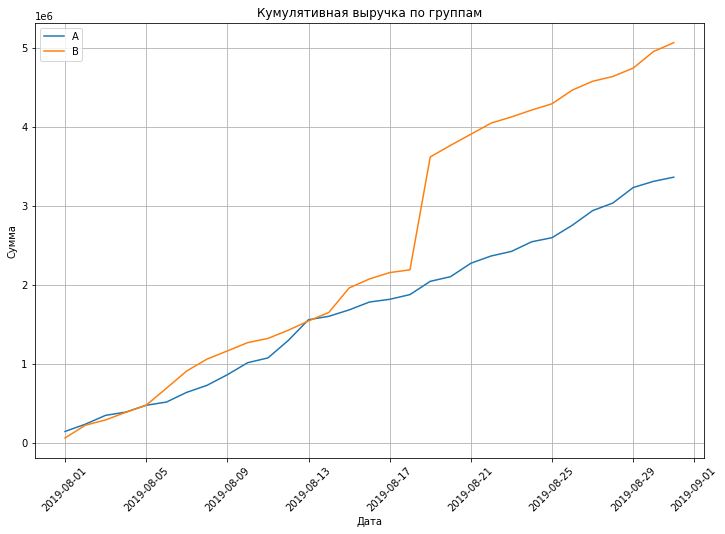

In [32]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize = (12, 8))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Кумулятивная выручка по группам')
plt.xticks(rotation = 45)
plt.xlabel('Дата') 
plt.ylabel('Сумма') 
plt.legend() 
plt.grid(True)
plt.show()

На графике мы видим, что выручка увеличивается в течение всего теста. Однако, если выручка группы А увеличивается почти равномерно, то график выручки группы В в одной точке резко вырос. Это может говорить о резком увеличении числа заказов, либо о появлении очень дорогих заказов в выборке.

**2. Построим графики среднего чека по группам, разделив кумулятивную выручку на кумулятивное число заказов**

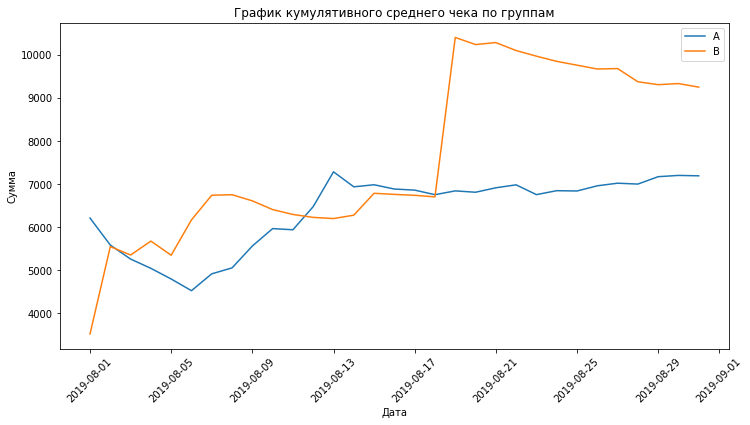

In [33]:
plt.figure(figsize = (12, 6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation = 45)
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')  
plt.ylabel('Сумма')
plt.legend() 
plt.show()

Средний чек сильно колеблется в первой половине графика и становится равномерным только ближе к концу теста. Причем у группы A средний чек стабилизировался, а в группе B плавно падает. Вероятно, в группу B попадали крупные заказы, которые отобразились всплесками на графике. Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку.

**3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A.**

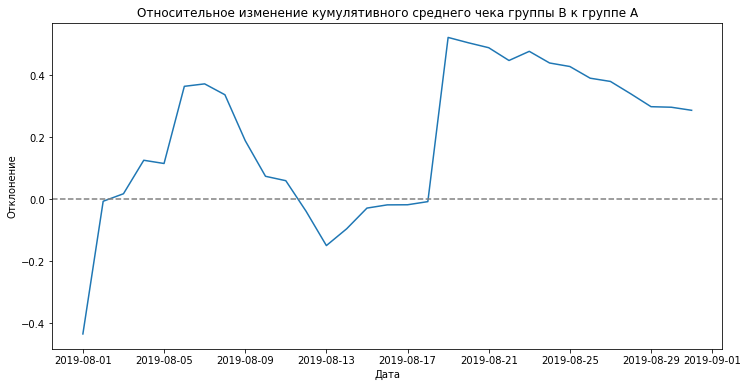

In [34]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize = (12, 6))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
# добавляем ось X
plt.axhline(y=0, color='grey', linestyle='--') 
plt.xlabel('Дата') 
plt.ylabel('Отклонение') 
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.show()

На полученном графике мы видим скачки в нескольких точках. По всей видимости в эти даты совершались аномальные заказы. 

**4. Построим график кумулятивного среднего количества заказов на посетителя по группам.**

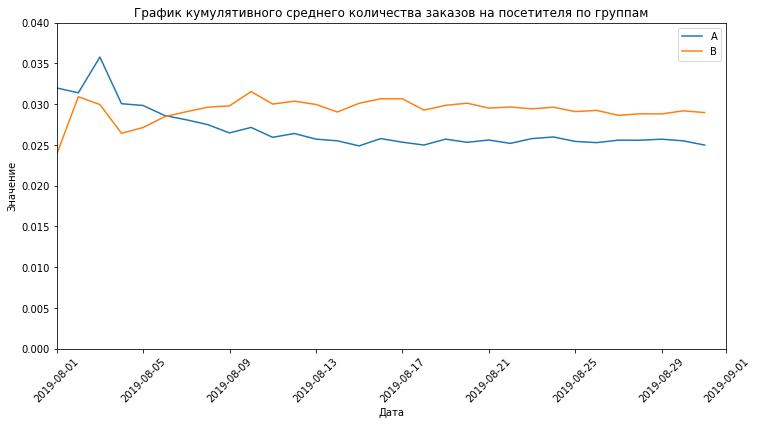

In [35]:
# определяем кумулятивное среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

# определяем данные по группам
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

# строим графики
plt.figure(figsize = (12, 6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.04])
plt.xlabel('Дата') 
plt.ylabel('Значение') 
plt.xticks(rotation = 45)
plt.show()


В самом начале теста сегмент А имел большее среднее количество заказов на посетителя, но приблизительно с 6 августа, сегмент В стал выше, а А наоборот ушел вниз. С этого момента на протяжении всего теста мы видим, что среднее количество заказов на посетителя в сегменте В стабильно выше, чем в А.

**5. Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.**

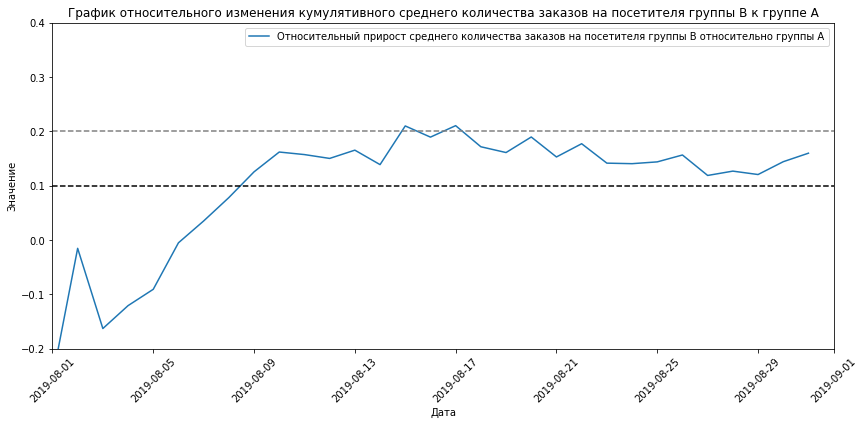

In [36]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize = (14, 6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост среднего количества заказов на посетителя группы B относительно группы A")
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.2, 0.4])
plt.axhline(y=0.1, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Значение') 
plt.legend()
plt.xticks(rotation = 45)
plt.show()

В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. Прирост среднего количества заказов на посетителя группы В относительно группы А примерно с 7-8 августа и до окончания теста установился между 10% и 20%.

**6. Посчитаем точечный график количества заказов по пользователям.**

In [37]:
# Посчитаем количество заказов по пользователям

ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['visitorid', 'orders']
print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

      visitorid  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


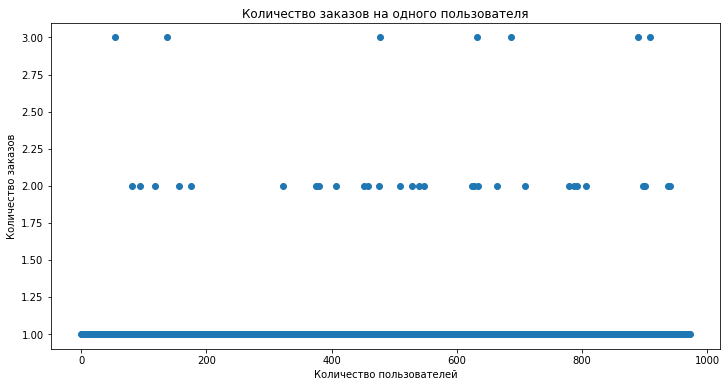

In [38]:
#Построим точечную диаграмму числа заказов на одного пользователя
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize = (12, 6))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Количество заказов на одного пользователя')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
plt.show()

Наибольшее количество пользователей совершают по одному заказу. Достаточно много пользователей встречается с 2-мя и 3-мя заказами, но т.к. их точная доля не ясна, мы не можем сделать вывод считать ли их аномалиями или нет. Для этого нужно посчитать выборочные перцентили количества заказов на одного пользователя.

**7. Построим 95-й и 99-й перцентили количества заказов на пользователя и выберем границу для определения аномальных пользователей.**

In [39]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

# сохраним значение 95-го перцентиля в переменной ordersNormal для дальнейших рассчетов
ordersNormal = int(np.percentile(ordersByUsers['orders'], [95])[0])
print(ordersNormal)

[1. 2.]
1


Не более 1% пользователей сделали более 2-х заказов, а 95% пользователей совершили всего по одному заказу. Количество заказов **больше 1-го** будем считать аномальным.

**8. Построим точечный график стоимостей заказов.**

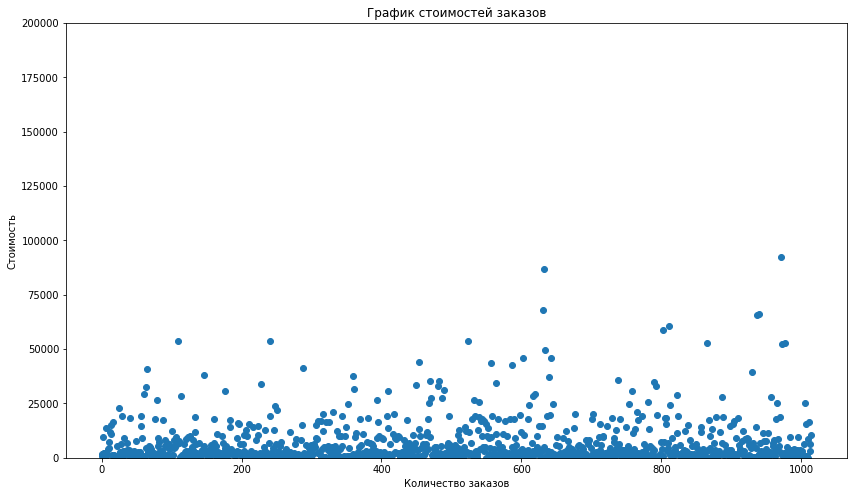

In [40]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize = (14, 8))
plt.scatter(x_values, orders['revenue'])
plt.title('График стоимостей заказов')
plt.ylim(0, 200000)
plt.xlabel('Количество заказов')
plt.ylabel('Стоимость')
plt.show()

На точечной диаграмме рассеивания видно, что большая часть заказов по графику не превышает 25 000 руб. Есть выбросы, достигающие 100 000 руб.

**9. Посчитаем 95-й и 99-й перцентили стоимости заказов и выберем границу для определения аномальных заказов.**

In [41]:
print(np.percentile(orders['revenue'], [95, 99]))

# сохраним значение 95-го перцентиля в переменной revenueNormal для дальнейших рассчетов
revenueNormal = int(np.percentile(orders['revenue'], [95])[0]) 
print(revenueNormal)

[26785. 53904.]
26785


Всего 5% заказов превышают стоимость **26 785 рублей** и не более 1% дороже 53 904 рублей. В качестве граничного значения будем считать 95-й перцентиль. Все заказы, стоимость которых превышает данное значение, не будут учитываться в тесте.

**10. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.**

Для расчёта значений статистической значимости для каждой группы теста подготовим таблицу, в которой будет содержаться следующая информация:

- date — дата
- ordersPerDateA — количество заказов в выбранную дату в группе A
- revenuePerDateA — суммарная выручка в выбранную дату в группе A
- ordersPerDateB — количество заказов в выбранную дату в группе B
- revenuePerDateB — суммарная выручка в выбранную дату в группе B
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B
- visitorsPerDateA — количество пользователей в выбранную дату в группе A
- visitorsPerDateB — количество пользователей в выбранную дату в группе B
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B

Сформулируем гипотезы. 

Нулевая (H0): различий в среднем количестве заказов между группами нет. 

Альтернативная (H1): различия в среднем между группами есть.

In [42]:
# создадим таблицу с данными о посещениях пользователей группы А
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

In [43]:
# создадим таблицу с данными о посещениях пользователей группы B
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [44]:
# определим кумулятивное количество посещений в день для группы А
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [45]:
# определим кумулятивное количество посещений в день для группы В
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [46]:
# создадим таблицу с количеством покупок в день и общей суммой покупок в день для группы А
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

In [47]:
# создадим таблицу с количеством покупок в день и общей суммой покупок в день для группы В
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [48]:
# создадим таблицу с кумулятивным количеством покупок и суммой покупок в день для группы А
ordersACummulative = (
        ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']]\
        .agg({'date' : 'max', 'ordersPerDateA' : 'sum', 'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date']))
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

In [49]:
# создадим таблицу с кумулятивным количеством покупок и суммой покупок в день для группы В
ordersBCummulative = (
        ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]\
        .agg({'date' : 'max', 'ordersPerDateB' : 'sum', 'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date']))
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [50]:
# объединим все таблицы, созданные выше, в одну таблицу "data"
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
display(data.head())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [51]:
# определим количество заказов для каждого уникального пользователя в группе А
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

In [52]:
# определим количество для каждого уникального пользователя в группе В
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

In [53]:
# создадим таблицу с количеством покупок для каждого клиента группы А (если клиент ничего не купил, то значение покупок равно 0)
sampleA = pd.concat(
    [ordersByUsersA['orders'], 
     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],
    axis=0)

In [54]:
# создадим таблицу с количеством покупок для каждого клиента группы В (если клиент ничего не купил, то значение покупок равно 0)
sampleB = pd.concat(
    [ordersByUsersB['orders'], pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],
    axis=0)

In [55]:
# рассчитаем значения статистической значимости среднего количества заказов на посетителя между группами
print('Значение статистической значимости среднего количества заказов между группами составляет', 
      ("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1])))

Значение статистической значимости среднего количества заказов между группами составляет 0.01102


In [56]:
# рассчитаем значения прироста среднего количества заказов на посетителя в группе В по отношению к группе А
print('Относительный прирост среднего группы В к группе А равен: ',
      "{0:.2%}".format(sampleB.mean() / sampleA.mean() - 1))

Относительный прирост среднего группы В к группе А равен:  15.98%


Так как значение p-value < 0.05, нулевую гипотезу мы отвергаем. Проведенный анализ сырых данных показал, что в среднем количестве заказов между группами есть статистически значимые отличия.

**11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.**

Нулевая гипотеза (H0): различий в среднем чеке между группами нет. 

Альтернативная гипотеза (H1): различия в среднем чеке между группами есть.

In [57]:
print('Cтатистическая значимость различия средних чеков между группами: ',
     '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

Cтатистическая значимость различия средних чеков между группами:  0.829


In [58]:
print('Относительный прирост среднего чека группы B: ',
     '{0:.2%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

Относительный прирост среднего чека группы B:  28.66%


P-value составил 0.829, что больше 0.05. Это означает, что мы не отвергать нулевую гипотезу о том, что различий в среднем чеке между гуппами нет статистически значимых отличий между группами нет. При этом средний чек группы В на 28.66% выше среднего чека группы А, что достаточно много. 

Данный анализ проводился на "сырых" данных, поэтому делать выводы об успешности А/В тестирования рано, необходимо перепроверить все расчёты на очищенных от аномалий данных.

**12. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.**

Для начала необходимо посчитать сколько пользователей попадают в категорию аномальных значений.

In [59]:
#из проведенных ранее рассчетов, мы относим к аномальным пользователям тех, кто сделал более одного заказа или сделал заказ
# на сумму выше 26 785
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > ordersNormal]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > ordersNormal]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > revenueNormal]['visitorId']

# объединим их в таблице abnormalUsers, удалим дубликаты, отсортируем по возрастанию.
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print('Количество аномальных пользователей: ', abnormalUsers.shape[0]) 

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64
Количество аномальных пользователей:  86


Теперь сделаем расчет статистической значимости различий среднего количества заказов после удаления аномальных пользователей.

Сначала подготовим выборки количества заказов по пользователям по группам теста.

In [60]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Применим статистический критерий Манна-Уитни к полученным выборкам.

In [61]:
print('Значение статистической значимости среднего количества заказов между группами составляет',
      '{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.2%}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

Значение статистической значимости среднего количества заказов между группами составляет 0.01593
17.39%


Проведенный анализ "очищенных" данных показал, что в среднем количестве заказов между группами есть статистически значимые отличия. 

Относительный прирост среднего группы В к группе А по очищенным данным выше, чем по "сырым" на: 
1.41% (17.39% - 15.98%)

**13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.**

Теперь сделаем расчет статистической значимости различий среднего количества заказов после удаления аномальных пользователей. 

Сначала подготовим выборки количества заказов по пользователям по группам теста.

In [62]:
# рассчитаем статистическую значимость в среднем чеке между группами А и В на очищенных данных
print('Cтатистическая значимость различия средних чеков между группами: ',
      '{0:.3f}'.format(stats.mannwhitneyu(
    orders[
        np.logical_and(
            orders['group'] == 'A', 
            np.logical_not(orders['visitorId'].isin(abnormalUsers)),
        )
    ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

# рассчитаем относительный прирост среднего чека очищенной группы B на очищенных данных
print('Относительный прирост среднего чека группы B: ',
    "{0:.3%}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

Cтатистическая значимость различия средних чеков между группами:  0.727
Относительный прирост среднего чека группы B:  -3.373%


Полученное значение статистической значимости в среднем чеке между группами по "очищенным" данным практически идентично значению полученному по "сырым" данным. Но после исключения аномальных значений удалось выяснить, что средний чек в группе В на 3% ниже чем в группе А. Данный показатель сильно отличается от значения полученного на "сырых" данных. Отличие составляет: 32.03% (28.66 -(-3.37)) Таким образом, исключение аномально высоких значений сильно повлияло на итоговый результат и позволило объективно посмотреть на статистику.

**14. Принятие решения по результатам теста.**

В ходе анализа результатов А/В-тестирования были получены следующие результаты:

- По значениям среднего количества заказов между группами А и В есть статистически значимое различие, как по сырым данным, так и после исключения аномалий.
- По среднему чеку статистически значимого различия между группами нет. При анализе сырых данных преимущество у группы В, при анализе очищенных данных - группа В по среднему чеку немного проигрывает.
- График различия среднего количества заказов между группами сообщает, что результаты у группы B лучше, чем у группы A. У группы В результат стабильно выше на 10% - 20%.
- График различия среднего чека колеблется. Именно эти колебания позволили обнаружить аномалии. Сделать из этого графика определённые выводы нельзя.

Таким образом, резюмируя вышеизложенные выводы, я бы рекомендовала остановить тест и признать его успешным, т.к. группа В по доходам показала результаты гораздо лучше, чем группа А. 

## Общий вывод

В результатам А/В-тестирования группа В выигрывает по следующим показателям:

 - **Кумулятивная выручка** ко дню последнего дня теста  выше, чем у группы А более чем на 1,5 млн. рублей
 - **Среднее количество заказов** - выше на 17,4 %. 

A/B-тест подтвердил гипотезу о лучшей производительности версии B по сравнению с версией A. Можем признать A/B-тест успешным.